# __Prediction of the isotopic inventory in a nuclear reactor core__

*Benjamin Dechenaux, Jean-Baptiste Clavel, Cécilia Damon (IRSN), François Caud, Alexandre Gramfort (DATAIA, Univ. Paris-Saclay)*

This challenge was done with the support of [DATAIA](https://dataia.eu) in collaboration with [IRSN](https://www.irsn.fr/FR/Pages/Home.aspx):

<table>
  <tr>
    <td style="background-color:#FFFFFF;">
        <a href="https://dataia.eu">
            <img src="https://github.com/ramp-kits/nuclear_inventory/raw/main/DATAIA-h.png" width="500px"/>
        </a>
    </td>
    <td style="background-color:#FFFFFF;">
        <a href="https://www.irsn.fr/FR/Pages/Home.aspx">
            <img src="https://www.irsn.fr/FR/IRSN/Publications/rapports-annuels/RA/Documents/RA2020/images/menu/logo-irsn.svg" width="250px"/>
        </a>
    </td>
  </tr>
 </table>

## Introduction 

Matter contained inside a nuclear reactor undergoes irradiation that causes successive cascades of nuclear reactions, modifying its atomic composition. Knowledge of this time evolving composition is an important parameter used to model the behavior of a nuclear reactor. But it is also a crucial input for __safety__ studies associated with its operation and is a key input __for the mitigation of a severe accident__. Knowing at a given instant the composition of a reactor allows to quickly assess what radioactive isotopes may be released in the environment. 

The modelling of the change in the atomic composition of irradiated materials over time is usually achieved using time expensive Monte Carlo simulations of the system being studied. Although precise, this calculation scheme has been found inadapted in crisis (i.e. accidental) situations, where faster calculation schemes have to be developped. 

This project aims at constructing a machine learning surrogate model capable at predicting the time changing nuclear inventory of a typical reactor of the French fleet. 

## Description of the data 

The atomic composition of the material subjected to irradiation usually involves thousands of isotopes. However, most of them have short lifetimes (characteristic decay time) and are not of critical interest for the safety of the facility or the mitigation of a reactor accident. 

In this project, we propose to track the temporal evolution of __26 isotopes__ that have a significant impact on the reactor behaviour or are isotopes whose compositions are a key input for the study of the mitigation of an accident (they might be isotopes that are usually found to be released in the environment in accidental scenarios, or are important for safety reasons in general). 

For non-proliferation reasons, the isotopes were renamed and each of them are identified by a unique letter of the alphabet (e.g. the first isotope considered is named "A").   

So we'll be interested in the evolution of the content in isotopes "A", "B", ..., "Z" inside a reactor with time. The isotope content at each time is expressed in some kind of density unity ( ~ number of atoms per cubic cm).  

### Modelling the irradiation in a nuclear reactor

To model the irradiation conditions of the nuclear materials, we suppose a simplified scheme for the temporal evolution.

Matter is put inside the reactor for a grand total of __1825 days__ (i.e. 5 years). 

This total period is subdivided into 5 different irradiation __cycles__ where each cycle corresponds to a 300 days period with a certain configuration of the reactor (its operating power). Each cycle is charaterized by a single parameter *pi* (with i running from 1 to 5).  

Between 2 cycles, a period of 65 days was added and correspond to a maintenance period for the reactor, where the fuel is not irradiated. Note that isotopes do evolve during this period, yet during these intercycle periods, we don't track the evolution of the isotopes content.

To summarize, the nuclear fuel is put inside of a reactor for a total of 1825 days with the following history :

* The fuel is irradiated for 300 days (from T = 0 to T = 300) with parameter *p1*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 365 to T = 665) with parameter *p2*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 730 to T = 1030) with parameter *p3*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 1095 to T = 1395) with parameter *p4*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 1460 to T = 1760) with parameter *p5*
* The fuel is put to rest for 65 days


For the sake of the exercise, the composition of each isotope will be tracked on a __20 days__ time interval basis, except for the periods where the fuel is put to rest, where the interval is 65 days (again, the evolution of fuel composition is not being tracked, but this doesn't mean it doesn't evolve...) . 


So in the end, for a given set of input data (which consists of the inital composition of isotopes A -> H and the 5 parameters p1,...,p5), the result is a time series of length 81 (initial composition + 80 timesteps).

See the 'One sample' section below to see plots of those time series.

### Description of the available data

The database we built is composed of a total of __920__ different reactor histories (i.e. time series), that were generated varying the initial conditions (i.e. the input parameters, see below) of the system and performing a detailled simulation of the reactor evolution in each case.  

For each of the 920 simulations, the composition of the 26 isotopes were tracked. These are the output data of the database (see below). 


#### Input data 

The input data is composed of the initial composition of the matter before irradiation and the 5 parameters p1, .. p5 that specify the global operating conditions of the reactor for each irradiation cycle.

**This initial composition of the matter is only composed of isotopes __A to H__ ** (all the other are always equal to zero at the initial time T=0).

For each of the generated data point, the initial conditions (which is the input for any surrogate model) is composed of those 13 paramaters :

* Initial composition in terms of isotopes A --> H (8 parameters)
* Operating conditions of the reactor p1, ... , p5 (5 parameters)

For each of the 920 differents simulations that were done, a unique set of values was picked in this initial input space using the latin hypercube method.

#### Output data 

For each point in the input space, a simulation of the time evolving composition of matter was performed. The result of a simulation is a time series of length 81 (initial composition + 80 timesteps) for each isotope (form A to Z. Note that isotopes I -> Z always have zero composition at T=0). 

Those times series are stored in CSV output files that can be found under the _data/train_ and _data/test_ folders.

__Remark__

To ease the manipulation of the time series, the additional p1, ..., p5 input parameters were added to each of their corresponding timesteps (e.g. a time series named p1 which have the same value for each entry of the time series).

## Requirements for running the notebook 

To properly run the notebook, the following Python modules must be imported :

In [1]:
# Required for running the notebook 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import string
import os


# sklearn dependences are used to build a baseline model 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

%matplotlib inline

# Exploratory data analysis

First, download the data executing this python script:

In [2]:
!python download_data.py

data directory is not empty. Please empty it or select another destination for LOCAL_DATA if you wish to proceed


### Loading the data 

The 920 simulations have been split into two *training* and *testing* datasets.

* The *training* dataset is composed of 690 simulations and is accessible in CSV format under the __train__ folder
* The *testing* dataset is composed of 230 simulations and is accessible in CSV format under the __test__ folder

Training and testing sets can be loaded as follows:

In [3]:
from glob import glob

def get_file_list_from_dir(*, path, datadir):
    data_files = sorted(glob(os.path.join(path, "data", datadir, "*.csv.gz")))
    return data_files

In [4]:
train_files = get_file_list_from_dir(path=".", datadir="train")
len(train_files)

690

In [5]:
dtrain = pd.concat((pd.read_csv(f) for f in train_files))
dtrain

,times,A,B,C,D,E,F,G,H,I,...,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.317729,3.265168,0.205470,1.316402,0.848285,0.364322,0.635073,0.173054,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.023597,0.006906,0.008332,0.035934,0.016353
1,20.0,0.316280,3.263388,0.204874,1.310603,0.847751,0.363267,0.634779,0.172712,0.000002,...,0.000018,0.000004,0.000079,0.000080,1.808307e-04,0.023597,0.006906,0.008332,0.035934,0.016353
2,40.0,0.314831,3.261604,0.204346,1.305081,0.847190,0.362233,0.634489,0.172364,0.000015,...,0.000040,0.000016,0.000267,0.000159,2.418617e-04,0.023597,0.006906,0.008332,0.035934,0.016353
3,60.0,0.313387,3.259812,0.203877,1.299572,0.846631,0.361196,0.634213,0.172015,0.000044,...,0.000062,0.000035,0.000494,0.000239,2.624485e-04,0.023597,0.006906,0.008332,0.035934,0.016353
4,80.0,0.311945,3.258014,0.203466,1.294071,0.846071,0.360163,0.633918,0.171660,0.000090,...,0.000085,0.000062,0.000736,0.000318,2.693822e-04,0.023597,0.006906,0.008332,0.035934,0.016353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1700.0,0.169739,3.433316,0.123249,0.965266,0.508759,0.633691,0.613137,0.324423,0.008339,...,0.001746,0.005862,0.012580,0.003470,1.302972e-05,0.021140,0.040212,0.003044,0.016795,0.001108
77,1720.0,0.169704,3.433221,0.123440,0.965082,0.508757,0.631893,0.613151,0.325956,0.008353,...,0.001748,0.005861,0.012591,0.003469,1.302924e-05,0.021140,0.040212,0.003044,0.016795,0.001108
78,1740.0,0.169668,3.433125,0.123616,0.964899,0.508754,0.630100,0.613166,0.327481,0.008366,...,0.001750,0.005860,0.012601,0.003468,1.303008e-05,0.021140,0.040212,0.003044,0.016795,0.001108
79,1760.0,0.169632,3.433030,0.123777,0.964714,0.508753,0.628313,0.613180,0.329002,0.008378,...,0.001752,0.005859,0.012612,0.003467,1.302903e-05,0.021140,0.040212,0.003044,0.016795,0.001108


In these dataframes, data have been concatenated one on top of the other.

We have 690 samples * 81 (length of each time series) = 55890 rows.

In [6]:
test_files = get_file_list_from_dir(path=".", datadir="test")
len(test_files)

230

In [7]:
dtest = pd.concat((pd.read_csv(f) for f in test_files))
dtest

,times,A,B,C,D,E,F,G,H,I,...,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.044514,0.011609,0.007466,0.002743,0.040281
1,20.0,0.132701,4.772421,0.399662,2.116149,0.784623,0.116937,0.761039,0.138697,0.000004,...,0.000036,0.000015,0.000145,0.000141,0.000331,0.044514,0.011609,0.007466,0.002743,0.040281
2,40.0,0.131602,4.768180,0.397866,2.101764,0.785669,0.119713,0.759411,0.137147,0.000028,...,0.000078,0.000059,0.000491,0.000282,0.000443,0.044514,0.011609,0.007466,0.002743,0.040281
3,60.0,0.130507,4.763926,0.396161,2.087453,0.786703,0.122439,0.757784,0.135616,0.000083,...,0.000122,0.000133,0.000910,0.000422,0.000481,0.044514,0.011609,0.007466,0.002743,0.040281
4,80.0,0.129422,4.759661,0.394536,2.073188,0.787729,0.125117,0.756160,0.134112,0.000173,...,0.000167,0.000233,0.001355,0.000562,0.000494,0.044514,0.011609,0.007466,0.002743,0.040281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1700.0,0.349419,5.362785,0.334786,2.214174,1.027648,0.302531,0.156441,0.200398,0.013778,...,0.002450,0.004512,0.020048,0.006538,0.000094,0.014510,0.024052,0.035835,0.048688,0.008009
77,1720.0,0.349006,5.362041,0.334873,2.212055,1.027713,0.301910,0.156495,0.200820,0.013851,...,0.002462,0.004540,0.020128,0.006558,0.000094,0.014510,0.024052,0.035835,0.048688,0.008009
78,1740.0,0.348592,5.361306,0.334943,2.209939,1.027774,0.301292,0.156549,0.201237,0.013922,...,0.002474,0.004568,0.020208,0.006578,0.000094,0.014510,0.024052,0.035835,0.048688,0.008009
79,1760.0,0.348177,5.360567,0.334995,2.207827,1.027837,0.300674,0.156603,0.201652,0.013989,...,0.002485,0.004597,0.020288,0.006597,0.000094,0.014510,0.024052,0.035835,0.048688,0.008009


### One sample
Let us first take a look at one of the 690 train samples (or simulations). We will put times as the index to ease plotting.

In [8]:
smpl1 = dtrain.reset_index(drop=True).iloc[:81]
smpl1 = smpl1.set_index('times')
smpl1

,A,B,C,D,E,F,G,H,I,J,...,V,W,X,Y,Z,p1,p2,p3,p4,p5
times,,,,,,,,,,,,,,,,,,,,,
0.0,0.317729,3.265168,0.205470,1.316402,0.848285,0.364322,0.635073,0.173054,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.023597,0.006906,0.008332,0.035934,0.016353
20.0,0.316280,3.263388,0.204874,1.310603,0.847751,0.363267,0.634779,0.172712,0.000002,0.000183,...,0.000018,0.000004,0.000079,0.000080,0.000181,0.023597,0.006906,0.008332,0.035934,0.016353
40.0,0.314831,3.261604,0.204346,1.305081,0.847190,0.362233,0.634489,0.172364,0.000015,0.000413,...,0.000040,0.000016,0.000267,0.000159,0.000242,0.023597,0.006906,0.008332,0.035934,0.016353
60.0,0.313387,3.259812,0.203877,1.299572,0.846631,0.361196,0.634213,0.172015,0.000044,0.000643,...,0.000062,0.000035,0.000494,0.000239,0.000262,0.023597,0.006906,0.008332,0.035934,0.016353
80.0,0.311945,3.258014,0.203466,1.294071,0.846071,0.360163,0.633918,0.171660,0.000090,0.000873,...,0.000085,0.000062,0.000736,0.000318,0.000269,0.023597,0.006906,0.008332,0.035934,0.016353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700.0,0.240961,3.157960,0.208606,1.019774,0.808000,0.297971,0.615205,0.167178,0.008587,0.011986,...,0.001778,0.009769,0.013276,0.004203,0.000189,0.023597,0.006906,0.008332,0.035934,0.016353
1720.0,0.240071,3.156546,0.208798,1.016284,0.807374,0.297375,0.614916,0.166946,0.008701,0.012124,...,0.001806,0.009983,0.013436,0.004251,0.000189,0.023597,0.006906,0.008332,0.035934,0.016353
1740.0,0.239182,3.155125,0.208985,1.012798,0.806741,0.296792,0.614635,0.166708,0.008814,0.012261,...,0.001833,0.010199,0.013596,0.004300,0.000189,0.023597,0.006906,0.008332,0.035934,0.016353


We can plot each individual isotope content vs times:

[Text(0.5, 1.0, 'Isotope A vs time')]

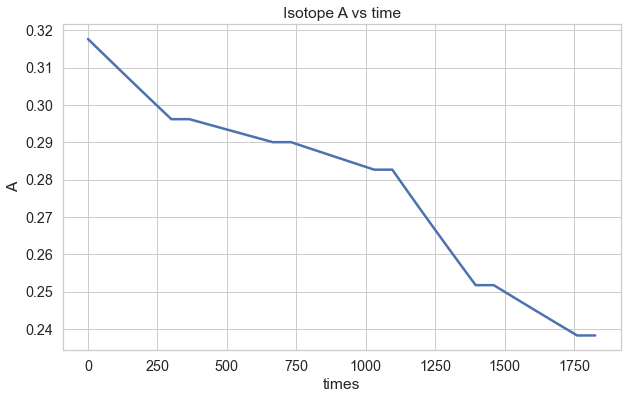

In [9]:
sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})

sns.lineplot(data=smpl1['A']).set(title="Isotope A vs time")

[Text(0.5, 1.0, 'Isotope J vs time')]

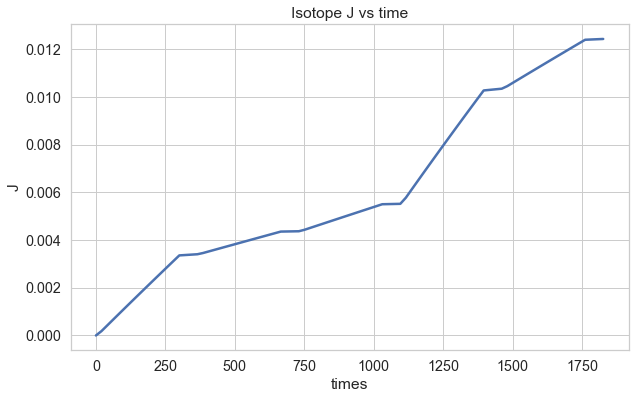

In [10]:
sns.lineplot(data=smpl1['J']).set(title="Isotope J vs time")

Plots reveal irradiation and maintenance cycles.

Let's plot all input composition:

[Text(0.5, 1.0, 'Input compos vs time')]

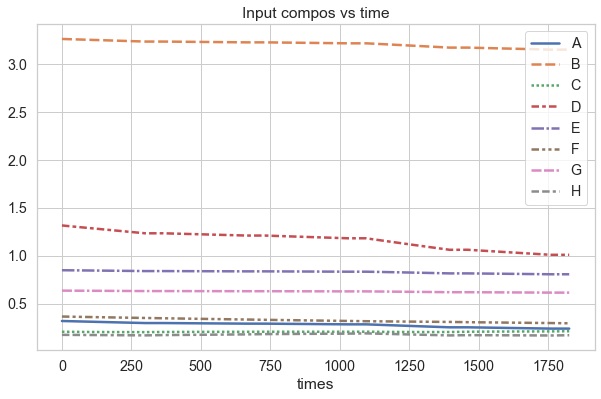

In [11]:
alphabet = list(string.ascii_uppercase)  # to ease the manipulation of the data

# The input compositions are isotopes A -> H  
input_compos = alphabet[:8]

sns.lineplot(data=smpl1[input_compos]).set(title="Input compos vs time")

We need a data scaling to better see all the curves. Isotope B is for example much higher than the other isotopes.

[Text(0.5, 1.0, 'Input composition (normalized) vs time')]

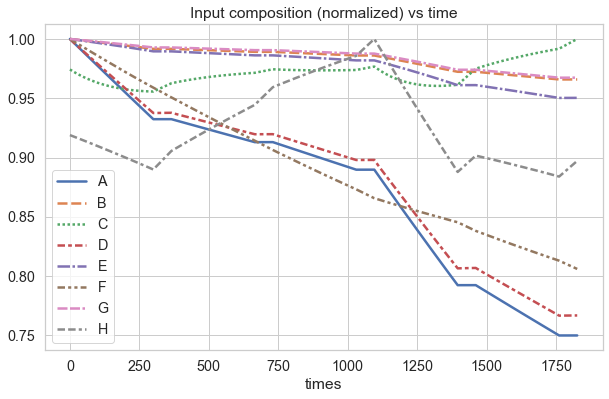

In [12]:
smpl1_max = smpl1.max()
smpl1_norm = smpl1 / smpl1_max

sns.lineplot(data=smpl1_norm[input_compos]).set(
    title="Input composition (normalized) vs time")

And the rest of the isotopes (except Z):

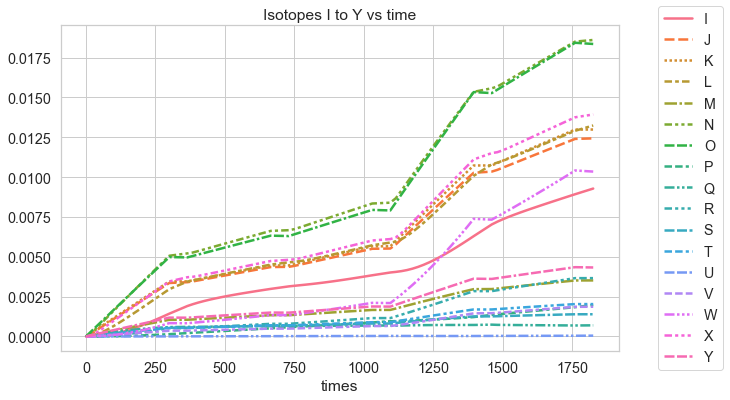

In [13]:
g = sns.lineplot(data=smpl1[alphabet[8: -1]])
g.set(title="Isotopes I to Y vs time")
g.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)

Normalized:

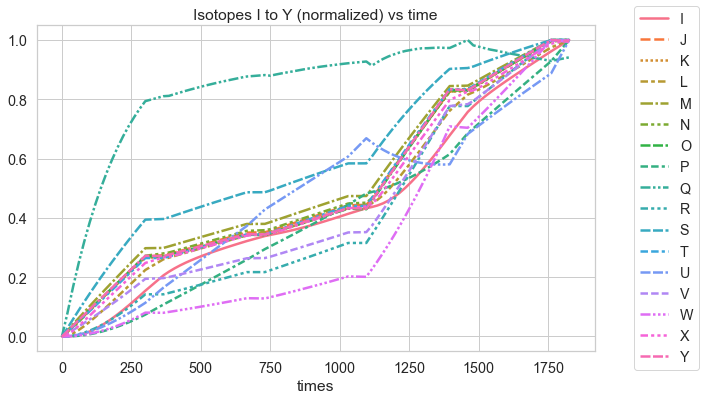

In [14]:
g = sns.lineplot(data=smpl1_norm[alphabet[8: -1]])
g.set(title="Isotopes I to Y (normalized) vs time")
g.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)

Z alone:

[Text(0.5, 1.0, 'Isotope Z vs time')]

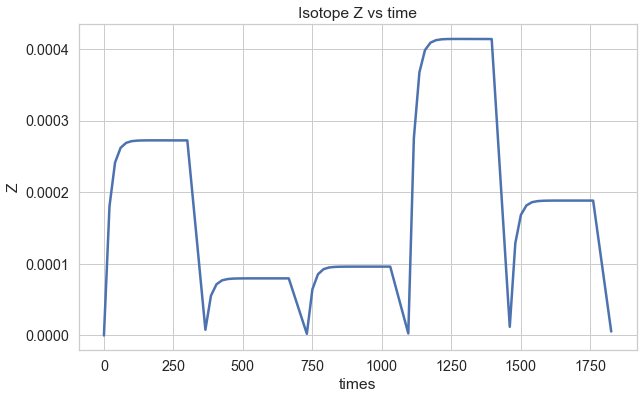

In [15]:
sns.lineplot(data=smpl1['Z']).set(title="Isotope Z vs time")

We want to see if there is a pairwise correlation between the time variation of isotopes. 
Let's compute the first discrete difference of element and plot the heatmap of the correlation between first isotopes:

<AxesSubplot:>

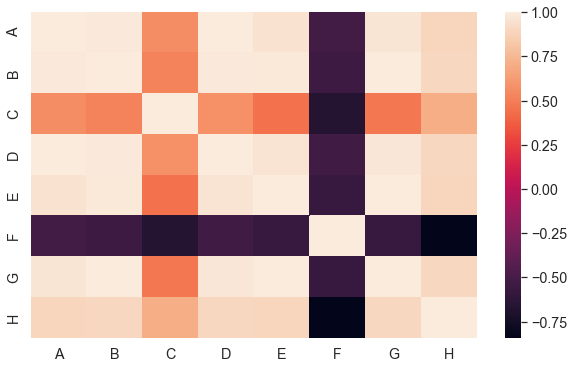

In [16]:
smpl1_diff = smpl1.diff()
sns.heatmap(smpl1_diff[input_compos].corr())

Here we see that for example A and D are positively correlated in their temporal variation (coefficient 1.00) and F and H are negatively correlated (coeff < -0.75).

And between all isotopes:

<AxesSubplot:>

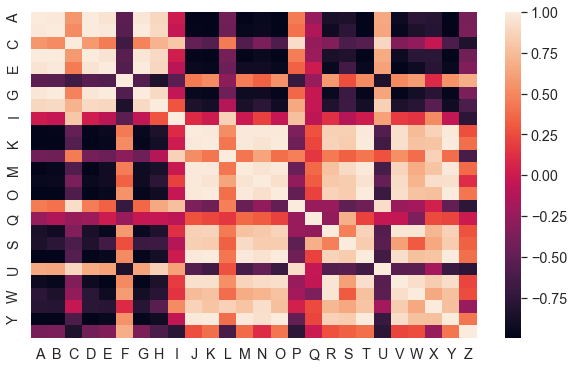

In [17]:
sns.heatmap(smpl1_diff[alphabet].corr())

It shows that the "input" isotopes that mainly decline have a strongly negative correlation in their time variation with almost all the other isotopes which are created in the five years time. Except for example for C and F which behave differently.

### Input and output data

To separate input data from output data, use the index of the dataframes or the "times" column.

The input data for instance is composed of the value of each T=0 entry in the datasets. To obtain those values, simply select every entry having T=0 in the train or test datasets : 

In [18]:
dtrain.loc[0].shape  # equivalent to dtrain.loc[dtrain["times"] == 0.]

(690, 32)

As said before, the train dataset regroup a total of 690 simulations that were performed varying the 13 input parameters listed above. Here the dataset is found to have 32 parameters at T=0, but only 13 are non zero, as can be seen using :  

In [19]:
dtrain.iloc[0]

times    0.000000
A        0.317729
B        3.265168
C        0.205470
D        1.316402
E        0.848285
F        0.364322
G        0.635073
H        0.173054
I        0.000000
J        0.000000
K        0.000000
L        0.000000
M        0.000000
N        0.000000
O        0.000000
P        0.000000
Q        0.000000
R        0.000000
S        0.000000
T        0.000000
U        0.000000
V        0.000000
W        0.000000
X        0.000000
Y        0.000000
Z        0.000000
p1       0.023597
p2       0.006906
p3       0.008332
p4       0.035934
p5       0.016353
Name: 0, dtype: float64

As adverstised, the initial compositions for isotopes "I" -> "Z" are zero, leaving only 13 input parameters. 
At T= 1825 days the (81th timestep), the composition has evolved :

In [20]:
dtrain.iloc[[0, 80]]

,times,A,B,C,D,E,F,G,H,I,...,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.317729,3.265168,0.205470,1.316402,0.848285,0.364322,0.635073,0.173054,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.023597,0.006906,0.008332,0.035934,0.016353
80,1825.0,0.238300,3.153707,0.210896,1.009524,0.806160,0.293671,0.614346,0.168961,0.009283,...,0.001866,0.010348,0.013931,0.00433,0.000006,0.023597,0.006906,0.008332,0.035934,0.016353


To get all of the unique timesteps, one can do:

In [21]:
timesteps = dtrain["times"].unique()
print(timesteps)

[   0.   20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.
  240.  260.  280.  300.  365.  385.  405.  425.  445.  465.  485.  505.
  525.  545.  565.  585.  605.  625.  645.  665.  730.  750.  770.  790.
  810.  830.  850.  870.  890.  910.  930.  950.  970.  990. 1010. 1030.
 1095. 1115. 1135. 1155. 1175. 1195. 1215. 1235. 1255. 1275. 1295. 1315.
 1335. 1355. 1375. 1395. 1460. 1480. 1500. 1520. 1540. 1560. 1580. 1600.
 1620. 1640. 1660. 1680. 1700. 1720. 1740. 1760. 1825.]


In [22]:
# The input parameters are composed of the input_compos + parameters p1 to p5 
input_params = input_compos + ["p1", "p2", "p3", "p4", "p5"]
input_params

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'p1', 'p2', 'p3', 'p4', 'p5']

## Normalization of the data

It is important to note that the composition data that make up the database are very heterogeneous. Indeed, the isotopes present in this database __have typical compositions that can present orders of magnitude of differences__. This can pose serious problems of normalization to succeed in learning the data at best. 

Let us for instance plot the distributions of the isotopes that makes up the input parameter composition (i.e. isotopes A to H) at the initial T=0 and final T=1825 times : 

<AxesSubplot:xlabel='isotope', ylabel='composition (a.u.)'>

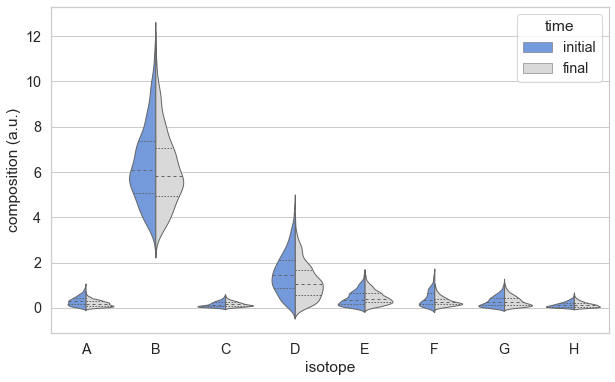

In [23]:
temp_initial = pd.DataFrame(
    dtrain.loc[0, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']].melt(
    value_name="composition (a.u.)", var_name="isotope")
)
temp_final = pd.DataFrame(
    dtrain.loc[80, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']].melt(
    value_name="composition (a.u.)", var_name="isotope")
)
temp_initial['time'] = 'initial'
temp_final['time'] = 'final'

temp = pd.concat([temp_initial, temp_final], axis=0)

# plot a violin plot for both the initial and final compositions of the input_compos  
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5, 'figure.figsize':(14, 8)})
sns.violinplot(
    data=temp,
    x="isotope",
    y="composition (a.u.)",
    hue="time",
    split=True,
    inner="quartile",
    linewidth=1,
    palette={"initial": "cornflowerblue", "final": ".85"},
)

As can be seen from the figure, most matter inside the reactor is made up of isotope B. 

The difficulty lies in the fact that we want, in the end, to have a precise __relative__ error on each individual isotope because it can happen that an isotope which is present in small quantities still has a non-negligible impact on the safety of the reactor and on the mitigation of an accident.

__So we can't just be good in the absolute overall composition of the matter: we need to be sufficiently precise for each individual isotope !__


The differences between the isotopes for the final compositions, adding all of the 26 isotopes, is even more visible:  

<AxesSubplot:xlabel='isotope', ylabel='composition (a.u.)'>

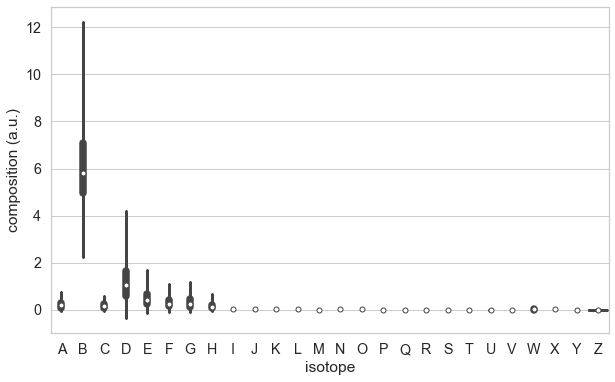

In [24]:
temp = pd.DataFrame(
    dtrain.loc[80, alphabet].melt(
    value_name="composition (a.u.)", var_name="isotope")
)
sns.violinplot(data=temp, x="isotope", y="composition (a.u.)", inner="box")

There, we want to be sufficiently precise on each individual isotopes, even if there exist ~ up to 5 orders of magnitudes between some isotopes ! 

In [25]:
dtrain.B.max(), dtrain.Z.max()

(11.71932, 0.0006211064)

__To achieve good overall performances for this challenge, it is believed that the first key is to find a clever way to  normalize the input and output data.__

In this notebook, we propose to normalize data just before feeding it into the models, i.e. normalize X and Y matrices. But just to see the effect of normalization, let's visualize isotope composition at a given time step after scaling.

You can change timestep in loc[ ] to see compositions at different times.

<AxesSubplot:xlabel='isotope', ylabel='composition (a.u.)'>

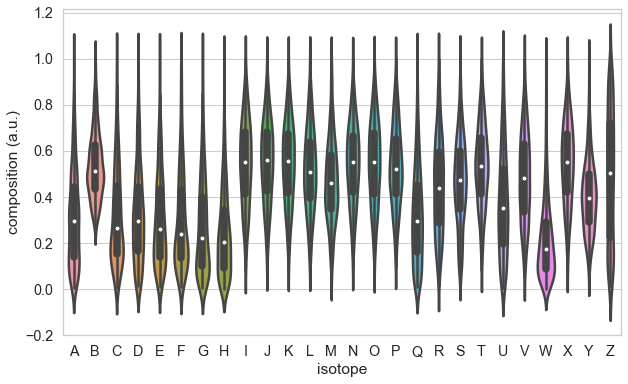

In [26]:
# dtrain at a certain timestep
temp = dtrain.loc[50, alphabet]
# scaling
temp = temp / temp.max()

temp = pd.DataFrame(
    temp.melt(
    value_name="composition (a.u.)", var_name="isotope")
)

sns.violinplot(data=temp,x="isotope",y="composition (a.u.)", inner="box")

## A simple baseline algorithm  

To benchmark the performances of a machine learning algorithm, we first try to build a simple baseline method.

Our goal is to predict the composition of matter inside the reactor **at any given time** by just using its initial composition (isotopes A --> H) and the parameters p1, ..., p5.

The baseline algorithm presented here simply performs a multioutput linear regression for each isotope. Here we have  80 timesteps as output in the predictive model.

Let us first reshape the data into a form that will be more useful for the rest of this notebook 

In [27]:
train_data = dtrain[alphabet].add_prefix('Y_')
train_data["times"] = dtrain["times"]
train_data = train_data[ train_data["times"] > 0.]
temp = dtrain.loc[0][input_params].reset_index(drop=True)
temp = temp.loc[temp.index.repeat(80)].reset_index(drop=True)
train_data = pd.concat([temp, train_data.reset_index(drop=True)], axis=1)
train_data

,A,B,C,D,E,F,G,H,p1,p2,...,Y_R,Y_S,Y_T,Y_U,Y_V,Y_W,Y_X,Y_Y,Y_Z,times
0,0.317729,3.265168,0.205470,1.316402,0.848285,0.364322,0.635073,0.173054,0.023597,0.006906,...,0.000003,0.000039,0.000034,3.737475e-08,0.000018,0.000004,0.000079,0.000080,1.808307e-04,20.0
1,0.317729,3.265168,0.205470,1.316402,0.848285,0.364322,0.635073,0.173054,0.023597,0.006906,...,0.000012,0.000081,0.000069,1.455940e-07,0.000040,0.000016,0.000267,0.000159,2.418617e-04,40.0
2,0.317729,3.265168,0.205470,1.316402,0.848285,0.364322,0.635073,0.173054,0.023597,0.006906,...,0.000027,0.000122,0.000104,3.190400e-07,0.000062,0.000035,0.000494,0.000239,2.624485e-04,60.0
3,0.317729,3.265168,0.205470,1.316402,0.848285,0.364322,0.635073,0.173054,0.023597,0.006906,...,0.000047,0.000163,0.000139,5.524009e-07,0.000085,0.000062,0.000736,0.000318,2.693822e-04,80.0
4,0.317729,3.265168,0.205470,1.316402,0.848285,0.364322,0.635073,0.173054,0.023597,0.006906,...,0.000073,0.000202,0.000175,8.406218e-07,0.000108,0.000097,0.000983,0.000398,2.717239e-04,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55195,0.210802,3.523721,0.082074,1.164630,0.514956,0.986465,0.590926,0.242705,0.021140,0.040212,...,0.003093,0.001547,0.002046,9.069067e-05,0.001746,0.005862,0.012580,0.003470,1.302972e-05,1700.0
55196,0.210802,3.523721,0.082074,1.164630,0.514956,0.986465,0.590926,0.242705,0.021140,0.040212,...,0.003097,0.001547,0.002047,9.225339e-05,0.001748,0.005861,0.012591,0.003469,1.302924e-05,1720.0
55197,0.210802,3.523721,0.082074,1.164630,0.514956,0.986465,0.590926,0.242705,0.021140,0.040212,...,0.003101,0.001547,0.002049,9.380330e-05,0.001750,0.005860,0.012601,0.003468,1.303008e-05,1740.0
55198,0.210802,3.523721,0.082074,1.164630,0.514956,0.986465,0.590926,0.242705,0.021140,0.040212,...,0.003105,0.001547,0.002051,9.534032e-05,0.001752,0.005859,0.012612,0.003467,1.302903e-05,1760.0


In [28]:
test_data = dtest[alphabet].add_prefix('Y_')
test_data["times"] = dtest["times"]
test_data = test_data[test_data["times"] > 0.]
temp = dtest.loc[0][input_params].reset_index(drop=True)
temp = temp.loc[temp.index.repeat(80)].reset_index(drop=True)
test_data = pd.concat([temp, test_data.reset_index(drop=True)], axis=1)
test_data

,A,B,C,D,E,F,G,H,p1,p2,...,Y_R,Y_S,Y_T,Y_U,Y_V,Y_W,Y_X,Y_Y,Y_Z,times
0,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,...,0.000008,0.000074,0.000065,7.151626e-08,0.000036,0.000015,0.000145,0.000141,0.000331,20.0
1,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,...,0.000033,0.000152,0.000131,2.741408e-07,0.000078,0.000059,0.000491,0.000282,0.000443,40.0
2,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,...,0.000074,0.000226,0.000197,5.910356e-07,0.000122,0.000133,0.000910,0.000422,0.000481,60.0
3,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,...,0.000128,0.000298,0.000265,1.007280e-06,0.000167,0.000233,0.001355,0.000562,0.000494,80.0
4,0.133810,4.776655,0.401556,2.131205,0.783545,0.114118,0.762691,0.140276,0.044514,0.011609,...,0.000194,0.000368,0.000332,1.509132e-06,0.000214,0.000360,0.001807,0.000702,0.000498,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18395,0.457563,5.532067,0.350256,2.744948,0.997465,0.341679,0.141960,0.215507,0.014510,0.024052,...,0.004523,0.002202,0.002959,9.559488e-05,0.002450,0.004512,0.020048,0.006538,0.000094,1700.0
18396,0.457563,5.532067,0.350256,2.744948,0.997465,0.341679,0.141960,0.215507,0.014510,0.024052,...,0.004550,0.002206,0.002970,9.788469e-05,0.002462,0.004540,0.020128,0.006558,0.000094,1720.0
18397,0.457563,5.532067,0.350256,2.744948,0.997465,0.341679,0.141960,0.215507,0.014510,0.024052,...,0.004576,0.002211,0.002982,1.001580e-04,0.002474,0.004568,0.020208,0.006578,0.000094,1740.0
18398,0.457563,5.532067,0.350256,2.744948,0.997465,0.341679,0.141960,0.215507,0.014510,0.024052,...,0.004602,0.002215,0.002994,1.024140e-04,0.002485,0.004597,0.020288,0.006597,0.000094,1760.0


### Train and test data:
From these dataframe, let us extract X_train, y_train, X_test and y_test for each isotope:

For isotope A:

In [29]:
train_target_A = train_data.groupby(input_params)['Y_A'].apply(list).apply(pd.Series).rename(
    columns=lambda x: 'A' + str(x + 1)).reset_index()
train_target_A

,A,B,C,D,E,F,G,H,p1,p2,...,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.005192,4.990765,0.126878,2.347393,0.315230,0.374373,0.078563,0.129959,0.027372,0.022840,...,0.004739,0.004734,0.004728,0.004722,0.004716,0.004711,0.004705,0.004700,0.004694,0.004703
1,0.006727,4.876231,0.174605,3.000470,0.931660,0.317459,0.026470,0.110731,0.020134,0.012753,...,0.006498,0.006491,0.006485,0.006479,0.006473,0.006467,0.006461,0.006456,0.006449,0.006461
2,0.007188,6.176172,0.109065,1.556984,0.296715,0.204958,0.154517,0.026233,0.027025,0.020994,...,0.005332,0.005297,0.005262,0.005228,0.005193,0.005158,0.005124,0.005089,0.005055,0.005060
3,0.008880,4.154490,0.077639,3.082386,0.109124,0.401981,0.252849,0.127539,0.016481,0.008402,...,0.007459,0.007448,0.007438,0.007427,0.007416,0.007406,0.007395,0.007385,0.007375,0.007387
4,0.011813,5.558284,0.438273,2.416261,0.662015,0.691550,0.417485,0.031835,0.017720,0.038619,...,0.010632,0.010628,0.010623,0.010618,0.010616,0.010612,0.010609,0.010605,0.010602,0.010611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.904926,9.835680,0.103366,0.609510,0.320723,0.024184,0.164953,0.086149,0.025203,0.043971,...,0.543602,0.539840,0.536089,0.532356,0.528637,0.524942,0.521263,0.517594,0.513942,0.513945
686,0.934583,9.466261,0.027023,0.384777,0.138869,0.226331,0.002109,0.075807,0.042623,0.043409,...,0.527536,0.523719,0.519918,0.516134,0.512357,0.508596,0.504846,0.501101,0.497381,0.497383
687,0.957282,10.214110,0.008380,0.111240,0.001545,0.003537,0.015444,0.001633,0.013751,0.037612,...,0.490326,0.482109,0.473979,0.465930,0.457960,0.450073,0.442256,0.434517,0.426852,0.426853
688,0.959747,10.057000,0.111717,0.656046,0.067865,0.107541,0.193227,0.013821,0.029813,0.033931,...,0.516493,0.512444,0.508408,0.504393,0.500389,0.496402,0.492426,0.488471,0.484538,0.484540


In [30]:
test_target_A = test_data.groupby(input_params)['Y_A'].apply(list).apply(pd.Series).rename(
    columns=lambda x: 'A' + str(x + 1)).reset_index()
test_target_A

,A,B,C,D,E,F,G,H,p1,p2,...,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.007282,5.636715,0.412482,2.093307,1.554593,1.225205,0.175682,0.049742,0.045963,0.026232,...,0.006851,0.006862,0.006874,0.006886,0.006898,0.006909,0.006922,0.006935,0.006947,0.006956
1,0.018082,4.220983,0.253170,1.590942,0.582395,1.075491,0.570636,0.130346,0.009426,0.001281,...,0.014952,0.014871,0.014790,0.014710,0.014631,0.014551,0.014472,0.014393,0.014316,0.014322
2,0.018187,8.435444,0.017857,0.118998,0.031198,0.009453,0.007955,0.009778,0.046906,0.001916,...,0.001510,0.001443,0.001380,0.001319,0.001260,0.001205,0.001152,0.001101,0.001053,0.001053
3,0.024323,7.804812,0.109733,0.485782,0.370916,0.187885,0.122907,0.108180,0.045575,0.039759,...,0.007914,0.007889,0.007865,0.007841,0.007817,0.007793,0.007769,0.007746,0.007722,0.007723
4,0.027303,3.948096,0.222217,1.507915,0.348863,1.006527,0.345910,0.118197,0.003194,0.031200,...,0.021365,0.021278,0.021191,0.021105,0.021018,0.020933,0.020847,0.020762,0.020677,0.020683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.877807,10.121250,0.056728,0.613247,0.027587,0.195462,0.026856,0.021091,0.022773,0.005447,...,0.600267,0.592330,0.584438,0.576583,0.568773,0.561010,0.553282,0.545612,0.537981,0.537983
226,0.897279,10.004340,0.027873,0.186502,0.048653,0.083877,0.038836,0.031195,0.040411,0.041649,...,0.376968,0.369650,0.362413,0.355268,0.348203,0.341228,0.334327,0.327512,0.320783,0.320784
227,0.916215,10.383010,0.007526,0.037894,0.022747,0.015970,0.008717,0.000682,0.024353,0.043407,...,0.283028,0.278262,0.273537,0.268883,0.264269,0.259712,0.255200,0.250743,0.246337,0.246338
228,0.972700,9.890109,0.029839,0.235201,0.051008,0.056772,0.037784,0.017580,0.009303,0.018152,...,0.639333,0.630878,0.622467,0.614114,0.605806,0.597561,0.589378,0.581238,0.573178,0.573179


In [31]:
X_train = train_target_A[input_params]
# scale X_train
max_X_train = X_train.max()
X_train = X_train / max_X_train
X_train

,A,B,C,D,E,F,G,H,p1,p2,p3,p4,p5
0,0.005363,0.425858,0.233685,0.519969,0.206268,0.241581,0.067691,0.240884,0.547926,0.458792,0.047443,0.385955,0.832317
1,0.006949,0.416085,0.321590,0.664632,0.609623,0.204855,0.022807,0.205243,0.403038,0.256179,0.091628,0.285955,0.939493
2,0.007425,0.527008,0.200877,0.344886,0.194153,0.132258,0.133134,0.048624,0.540978,0.421714,0.377074,0.563385,0.890780
3,0.009173,0.354499,0.142997,0.682777,0.071404,0.259396,0.217858,0.236398,0.329918,0.168780,0.949347,0.572730,0.324807
4,0.012203,0.474284,0.807217,0.535224,0.433183,0.446254,0.359711,0.059008,0.354717,0.775757,0.477787,0.711153,0.880216
...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.934802,0.839271,0.190380,0.135012,0.209862,0.015606,0.142126,0.159681,0.504507,0.883250,0.142299,0.711716,0.454782
686,0.965438,0.807748,0.049772,0.085232,0.090867,0.146050,0.001817,0.140511,0.853211,0.871958,0.175744,0.545873,0.418075
687,0.988886,0.871562,0.015433,0.024641,0.001011,0.002283,0.013307,0.003028,0.275266,0.755523,0.489252,0.128342,0.622672
688,0.991432,0.858156,0.205763,0.145320,0.044407,0.069396,0.166487,0.025618,0.596790,0.681584,0.732292,0.825660,0.488552


In [32]:
y_train_A = train_target_A.iloc[:, len(input_params):]
# scale y_train_A
max_y_train_A = y_train_A.max()
y_train_A = y_train_A / max_y_train_A
y_train_A

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.005417,0.005439,0.005448,0.005457,0.005466,0.005475,0.005485,0.005495,0.005505,0.005516,...,0.007110,0.007107,0.007104,0.007101,0.007097,0.007094,0.007091,0.007089,0.007085,0.007099
1,0.007030,0.007071,0.007093,0.007116,0.007139,0.007163,0.007187,0.007212,0.007237,0.007263,...,0.009748,0.009746,0.009744,0.009742,0.009740,0.009739,0.009737,0.009736,0.009734,0.009752
2,0.007485,0.007501,0.007498,0.007495,0.007492,0.007490,0.007488,0.007486,0.007485,0.007484,...,0.008000,0.007953,0.007906,0.007860,0.007814,0.007768,0.007722,0.007676,0.007630,0.007637
3,0.009284,0.009342,0.009375,0.009409,0.009442,0.009477,0.009511,0.009546,0.009582,0.009617,...,0.011191,0.011183,0.011175,0.011167,0.011160,0.011152,0.011145,0.011138,0.011131,0.011149
4,0.012348,0.012421,0.012463,0.012506,0.012549,0.012593,0.012639,0.012685,0.012731,0.012779,...,0.015950,0.015956,0.015961,0.015966,0.015974,0.015981,0.015988,0.015995,0.016003,0.016016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.941855,0.943366,0.942399,0.941445,0.940489,0.939533,0.938591,0.937660,0.936715,0.935777,...,0.815546,0.810511,0.805485,0.800478,0.795484,0.790519,0.785571,0.780632,0.775709,0.775711
686,0.968933,0.966641,0.961778,0.956888,0.951965,0.947015,0.942026,0.936994,0.931933,0.926850,...,0.791442,0.786307,0.781188,0.776086,0.770986,0.765903,0.760830,0.755757,0.750712,0.750714
687,0.997376,0.999992,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.735618,0.723834,0.712163,0.700597,0.689130,0.677773,0.666503,0.655336,0.644262,0.644261
688,0.998681,1.000000,0.998694,0.997368,0.996024,0.994670,0.993306,0.991914,0.990504,0.989092,...,0.774875,0.769379,0.763893,0.758431,0.752977,0.747541,0.742112,0.736709,0.731328,0.731329


In [33]:
X_test = test_target_A[input_params]
# scale X_test the same way X_train was scaled
X_test = X_test / max_X_train
X_test

,A,B,C,D,E,F,G,H,p1,p2,p3,p4,p5
0,0.007523,0.480976,0.759716,0.463687,1.017233,0.790619,0.151370,0.092199,0.920067,0.526934,0.865575,0.576617,0.589161
1,0.018679,0.360173,0.466292,0.352408,0.381084,0.694009,0.491669,0.241601,0.188677,0.025735,0.694389,0.880378,0.965078
2,0.018788,0.719790,0.032890,0.026359,0.020414,0.006100,0.006854,0.018124,0.938942,0.038497,0.155534,0.389847,0.417847
3,0.025126,0.665978,0.202108,0.107605,0.242705,0.121241,0.105899,0.200516,0.912311,0.798647,0.968925,0.715934,0.141899
4,0.028204,0.336888,0.409283,0.334017,0.228275,0.649507,0.298041,0.219083,0.063933,0.626713,0.926961,0.330878,0.550075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.906787,0.863638,0.104482,0.135840,0.018051,0.126131,0.023140,0.039094,0.455852,0.109425,0.350386,0.631457,0.897085
226,0.926902,0.853662,0.051338,0.041312,0.031836,0.054126,0.033461,0.057822,0.808922,0.836620,0.093961,0.718253,0.763929
227,0.946463,0.885974,0.013861,0.008394,0.014885,0.010305,0.007510,0.001265,0.487485,0.871916,0.895170,0.351277,0.484065
228,1.004813,0.843915,0.054957,0.052099,0.033377,0.036635,0.032555,0.032586,0.186215,0.364629,0.702929,0.035355,0.676715


In [34]:
y_test_A = test_target_A.iloc[:, len(input_params):]
y_test_A

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.007246,0.007210,0.007175,0.007142,0.007109,0.007077,0.007046,0.007016,0.006987,0.006958,...,0.006851,0.006862,0.006874,0.006886,0.006898,0.006909,0.006922,0.006935,0.006947,0.006956
1,0.018060,0.018038,0.018016,0.017994,0.017972,0.017951,0.017929,0.017908,0.017886,0.017865,...,0.014952,0.014871,0.014790,0.014710,0.014631,0.014551,0.014472,0.014393,0.014316,0.014322
2,0.017000,0.015852,0.014747,0.013688,0.012674,0.011708,0.010791,0.009925,0.009110,0.008346,...,0.001510,0.001443,0.001380,0.001319,0.001260,0.001205,0.001152,0.001101,0.001053,0.001053
3,0.023882,0.023448,0.023021,0.022600,0.022186,0.021779,0.021378,0.020984,0.020595,0.020213,...,0.007914,0.007889,0.007865,0.007841,0.007817,0.007793,0.007769,0.007746,0.007722,0.007723
4,0.027292,0.027281,0.027270,0.027259,0.027248,0.027237,0.027226,0.027215,0.027204,0.027194,...,0.021365,0.021278,0.021191,0.021105,0.021018,0.020933,0.020847,0.020762,0.020677,0.020683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.873388,0.868957,0.864537,0.860111,0.855689,0.851269,0.846855,0.842436,0.838020,0.833612,...,0.600267,0.592330,0.584438,0.576583,0.568773,0.561010,0.553282,0.545612,0.537981,0.537983
226,0.885411,0.873605,0.861860,0.850191,0.838585,0.827061,0.815588,0.804189,0.792859,0.781609,...,0.376968,0.369650,0.362413,0.355268,0.348203,0.341228,0.334327,0.327512,0.320783,0.320784
227,0.906209,0.896268,0.886418,0.876653,0.866961,0.857349,0.847811,0.838355,0.828977,0.819667,...,0.283028,0.278262,0.273537,0.268883,0.264269,0.259712,0.255200,0.250743,0.246337,0.246338
228,0.969906,0.967113,0.964323,0.961538,0.958754,0.955970,0.953193,0.950415,0.947641,0.944873,...,0.639333,0.630878,0.622467,0.614114,0.605806,0.597561,0.589378,0.581238,0.573178,0.573179


We can now apply a multioutput algorithm:

In [35]:
model = LinearRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=57)
scores = cross_val_score(model, X_train, y_train_A, cv=cv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
errors = -scores
print(errors)
print(errors.mean())

[0.25346852 0.20156435 0.21988226 0.17279623 0.14846828 0.23597558
 0.16959568 0.22835256 0.20292559 0.26815275]
0.2101181794822216


In [36]:
model.fit(X_train, y_train_A)
y_pred_A = model.predict(X_test)
y_pred_A = pd.DataFrame(y_pred_A, columns=y_train_A.columns) * max_y_train_A
y_pred_A

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A71,A72,A73,A74,A75,A76,A77,A78,A79,A80
0,0.006891,0.006502,0.006115,0.005730,0.005347,0.004967,0.004588,0.004212,0.003837,0.003464,...,0.030477,0.031052,0.031618,0.032173,0.032719,0.033255,0.033780,0.034296,0.034801,0.034810
1,0.019652,0.021211,0.022758,0.024294,0.025817,0.027329,0.028829,0.030318,0.031795,0.033260,...,0.042582,0.041583,0.040592,0.039609,0.038634,0.037667,0.036709,0.035758,0.034816,0.034822
2,0.014498,0.010851,0.007249,0.003691,0.000176,-0.003295,-0.006725,-0.010113,-0.013459,-0.016765,...,-0.052174,-0.052683,-0.053174,-0.053648,-0.054105,-0.054544,-0.054968,-0.055374,-0.055763,-0.055763
3,0.021342,0.018394,0.015486,0.012614,0.009777,0.006976,0.004210,0.001478,-0.001219,-0.003883,...,-0.085446,-0.084755,-0.084059,-0.083360,-0.082655,-0.081947,-0.081235,-0.080519,-0.079800,-0.079800
4,0.029087,0.030858,0.032614,0.034356,0.036084,0.037798,0.039498,0.041184,0.042856,0.044514,...,0.043116,0.042981,0.042847,0.042714,0.042582,0.042451,0.042321,0.042192,0.042062,0.042068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.872249,0.866714,0.861206,0.855725,0.850270,0.844842,0.839442,0.834067,0.828719,0.823398,...,0.554449,0.549374,0.544335,0.539334,0.534370,0.529443,0.524552,0.519698,0.514883,0.514886
226,0.889980,0.882714,0.875487,0.868297,0.861146,0.854033,0.846960,0.839924,0.832927,0.825968,...,0.514757,0.509884,0.505048,0.500249,0.495488,0.490764,0.486078,0.481429,0.476818,0.476818
227,0.909943,0.903698,0.897486,0.891307,0.885159,0.879044,0.872962,0.866910,0.860891,0.854904,...,0.526946,0.522686,0.518457,0.514259,0.510094,0.505960,0.501858,0.497787,0.493749,0.493748
228,0.967548,0.962412,0.957295,0.952198,0.947121,0.942063,0.937027,0.932009,0.927011,0.922034,...,0.625969,0.620853,0.615772,0.610726,0.605716,0.600742,0.595802,0.590898,0.586030,0.586031


In [37]:
MAPE = mean_absolute_percentage_error(y_test_A, y_pred_A)
print(f"MAPE={MAPE:.4f}")

MAPE=0.3392


Treating all isotopes at once:

In [38]:
y_train_all = []
for i in alphabet:
    y_train_all.append(
        train_data.groupby(input_params)['Y_'+i].apply(list).apply(pd.Series).rename(
        columns=lambda x: i + str(x + 1)).reset_index().iloc[:, len(input_params):]
    )
    
y_train_all = pd.concat(y_train_all, axis=1)
# scale y_train_all
max_y_train_all = y_train_all.max()
y_train_all = y_train_all / max_y_train_all
y_train_all

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80
0,0.005417,0.005439,0.005448,0.005457,0.005466,0.005475,0.005485,0.005495,0.005505,0.005516,...,0.791647,0.792379,0.793139,0.793866,0.794622,0.795352,0.796098,0.796821,0.797535,0.797532
1,0.007030,0.007071,0.007093,0.007116,0.007139,0.007163,0.007187,0.007212,0.007237,0.007263,...,0.891521,0.892401,0.893314,0.894185,0.895065,0.895927,0.896823,0.897639,0.898526,0.898522
2,0.007485,0.007501,0.007498,0.007495,0.007492,0.007490,0.007488,0.007486,0.007485,0.007484,...,0.866115,0.867118,0.867951,0.868897,0.869789,0.870677,0.871363,0.872320,0.873218,0.879094
3,0.009284,0.009342,0.009375,0.009409,0.009442,0.009477,0.009511,0.009546,0.009582,0.009617,...,0.308313,0.308591,0.308891,0.309178,0.309460,0.309742,0.310033,0.310309,0.310587,0.310586
4,0.012348,0.012421,0.012463,0.012506,0.012549,0.012593,0.012639,0.012685,0.012731,0.012779,...,0.840706,0.841477,0.842276,0.843048,0.843833,0.844618,0.845397,0.846158,0.846919,0.846917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.941855,0.943366,0.942399,0.941445,0.940489,0.939533,0.938591,0.937660,0.936715,0.935777,...,0.464552,0.464854,0.465288,0.465636,0.465994,0.466309,0.466683,0.467043,0.467328,0.470475
686,0.968933,0.966641,0.961778,0.956888,0.951965,0.947015,0.942026,0.936994,0.931933,0.926850,...,0.430151,0.430507,0.430812,0.431161,0.431496,0.431834,0.432148,0.432508,0.432802,0.435715
687,0.997376,0.999992,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.662031,0.662120,0.662163,0.662208,0.662279,0.662278,0.662345,0.662416,0.662534,0.662535
688,0.998681,1.000000,0.998694,0.997368,0.996024,0.994670,0.993306,0.991914,0.990504,0.989092,...,0.499401,0.499734,0.500127,0.500505,0.500890,0.501301,0.501699,0.502053,0.502394,0.502394


In [39]:
y_test_all = []
for i in alphabet:
    y_test_all.append(
        test_data.groupby(input_params)['Y_'+i].apply(list).apply(pd.Series).rename(
        columns=lambda x: i + str(x + 1)).reset_index().iloc[:, len(input_params):]
    )
    
y_test_all = pd.concat(y_test_all, axis=1)
y_test_all

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80
0,0.007246,0.007210,0.007175,0.007142,0.007109,0.007077,0.007046,0.007016,0.006987,0.006958,...,0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,0.000010
1,0.018060,0.018038,0.018016,0.017994,0.017972,0.017951,0.017929,0.017908,0.017886,0.017865,...,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548,0.000016
2,0.017000,0.015852,0.014747,0.013688,0.012674,0.011708,0.010791,0.009925,0.009110,0.008346,...,0.000239,0.000239,0.000239,0.000239,0.000239,0.000239,0.000239,0.000239,0.000239,0.000007
3,0.023882,0.023448,0.023021,0.022600,0.022186,0.021779,0.021378,0.020984,0.020595,0.020213,...,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000081,0.000002
4,0.027292,0.027281,0.027270,0.027259,0.027248,0.027237,0.027226,0.027215,0.027204,0.027194,...,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000319,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.873388,0.868957,0.864537,0.860111,0.855689,0.851269,0.846855,0.842436,0.838020,0.833612,...,0.000542,0.000542,0.000542,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000016
226,0.885411,0.873605,0.861860,0.850191,0.838585,0.827061,0.815588,0.804189,0.792859,0.781609,...,0.000467,0.000467,0.000466,0.000466,0.000466,0.000465,0.000465,0.000465,0.000464,0.000014
227,0.906209,0.896268,0.886418,0.876653,0.866961,0.857349,0.847811,0.838355,0.828977,0.819667,...,0.000295,0.000295,0.000295,0.000294,0.000294,0.000294,0.000294,0.000294,0.000293,0.000009
228,0.969906,0.967113,0.964323,0.961538,0.958754,0.955970,0.953193,0.950415,0.947641,0.944873,...,0.000420,0.000420,0.000420,0.000420,0.000420,0.000419,0.000419,0.000419,0.000419,0.000012


In [40]:
model = LinearRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=57)
scores = cross_val_score(model, X_train, y_train_all, cv=cv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
errors = -scores
errors.mean()

0.5278524309265933

In [41]:
model.fit(X_train, y_train_all)
y_pred_all = model.predict(X_test)
y_pred_all = pd.DataFrame(y_pred_all, columns=y_train_all.columns) * max_y_train_all
y_pred_all

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80
0,0.006891,0.006502,0.006115,0.005730,0.005347,0.004967,0.004588,0.004212,0.003837,0.003464,...,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000010
1,0.019652,0.021211,0.022758,0.024294,0.025817,0.027329,0.028829,0.030318,0.031795,0.033260,...,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.000552,0.000016
2,0.014498,0.010851,0.007249,0.003691,0.000176,-0.003295,-0.006725,-0.010113,-0.013459,-0.016765,...,0.000241,0.000241,0.000241,0.000241,0.000240,0.000240,0.000240,0.000240,0.000240,0.000007
3,0.021342,0.018394,0.015486,0.012614,0.009777,0.006976,0.004210,0.001478,-0.001219,-0.003883,...,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000079,0.000002
4,0.029087,0.030858,0.032614,0.034356,0.036084,0.037798,0.039498,0.041184,0.042856,0.044514,...,0.000313,0.000314,0.000314,0.000314,0.000314,0.000314,0.000314,0.000313,0.000313,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.872249,0.866714,0.861206,0.855725,0.850270,0.844842,0.839442,0.834067,0.828719,0.823398,...,0.000530,0.000530,0.000530,0.000530,0.000530,0.000530,0.000529,0.000529,0.000529,0.000016
226,0.889980,0.882714,0.875487,0.868297,0.861146,0.854033,0.846960,0.839924,0.832927,0.825968,...,0.000455,0.000455,0.000455,0.000454,0.000454,0.000454,0.000454,0.000454,0.000454,0.000013
227,0.909943,0.903698,0.897486,0.891307,0.885159,0.879044,0.872962,0.866910,0.860891,0.854904,...,0.000294,0.000294,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000009
228,0.967548,0.962412,0.957295,0.952198,0.947121,0.942063,0.937027,0.932009,0.927011,0.922034,...,0.000406,0.000406,0.000405,0.000405,0.000405,0.000405,0.000405,0.000405,0.000405,0.000012


In [42]:
MAPE = mean_absolute_percentage_error(y_test_all, y_pred_all)
print(f"MAPE={MAPE:.4f}")

MAPE=1.3653


A proposed machine learning algorithm should at least beat this number.

## A naive MLP attempt

Let's see now if one can do better with a multilayer perceptron (MLP).

In [43]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(
    solver="adam", hidden_layer_sizes=(100,100,100), max_iter=300,
    batch_size=100, random_state=57)

In [44]:
model.fit(X_train, y_train_all)

MLPRegressor(batch_size=100, hidden_layer_sizes=(100, 100, 100), max_iter=300,
             random_state=57)

In [45]:
y_pred_all = model.predict(X_test)
y_pred_all = pd.DataFrame(y_pred_all, columns=y_train_all.columns) * max_y_train_all
y_pred_all

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,Z71,Z72,Z73,Z74,Z75,Z76,Z77,Z78,Z79,Z80
0,0.025002,0.047413,0.047657,0.031935,0.033642,0.056091,0.020563,0.011744,0.034383,0.037488,...,0.000336,0.000356,0.000351,0.000339,0.000344,0.000337,0.000343,0.000348,0.000347,0.000010
1,0.064956,0.049174,0.059578,0.048637,0.052147,0.059152,0.078862,0.060323,0.062352,0.063733,...,0.000528,0.000517,0.000520,0.000516,0.000528,0.000518,0.000520,0.000517,0.000523,0.000015
2,0.080815,0.058416,0.070292,0.039943,0.060017,0.050410,0.044948,0.029302,0.047457,0.049800,...,0.000245,0.000237,0.000249,0.000264,0.000253,0.000241,0.000256,0.000249,0.000238,0.000007
3,0.042448,0.044963,0.028303,0.015428,0.024725,0.014375,0.022633,0.002131,-0.000340,0.025022,...,0.000082,0.000076,0.000089,0.000102,0.000080,0.000082,0.000101,0.000092,0.000087,0.000003
4,0.057138,0.046485,0.061710,0.055913,0.059679,0.066038,0.072629,0.065307,0.070598,0.072602,...,0.000320,0.000325,0.000314,0.000325,0.000322,0.000319,0.000313,0.000321,0.000317,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.873506,0.879221,0.870521,0.870107,0.850982,0.860596,0.843687,0.844033,0.835398,0.828234,...,0.000486,0.000486,0.000484,0.000476,0.000488,0.000479,0.000487,0.000487,0.000489,0.000014
226,0.887949,0.885970,0.869607,0.857264,0.843754,0.843269,0.850758,0.834175,0.810197,0.836554,...,0.000421,0.000405,0.000416,0.000417,0.000417,0.000414,0.000428,0.000415,0.000420,0.000012
227,0.889007,0.885526,0.872733,0.873183,0.850967,0.844750,0.866006,0.852681,0.831363,0.855886,...,0.000304,0.000287,0.000283,0.000289,0.000286,0.000281,0.000300,0.000289,0.000290,0.000009
228,0.919666,0.906649,0.908895,0.910081,0.888506,0.890943,0.898566,0.894921,0.886417,0.874892,...,0.000394,0.000389,0.000379,0.000372,0.000386,0.000379,0.000382,0.000385,0.000380,0.000011


In [46]:
MAPE = mean_absolute_percentage_error(y_test_all, y_pred_all)
print(f"MAPE={MAPE:.4f}")

MAPE=0.9728


## Quick submission test

Finally, make sure the local processing goes through by running the
```
ramp-test --submission <submission folder>
```
If you want to quickly test the that there are no obvious code errors, use the `--quick-test` flag to only use a small subset of the data (training and testing sets with 5 elements each).

```
ramp-test --submission <submission folder> --quick-test
```

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.